# Random Forest Notebook
---
<b>Course: Independent Research Project (COM00151M)<b><br>
<b>Author: A.Krauskopf<b><br>
<b>Last Update: 4 August 2024<b>

This notebook includes the iterative experiment code and figure creation focusing on both non-differentially private and differentially private instances of the random forest ensemble method. It depends upon the .csv files referenced to reside in the Datasets subfolder in the same directory as this notebook. It also requires a Figures subfolder for the resulting imagery to be saved to.

<b>Package Prerequisites:<b>
- pandas
- numpy
- matplotlib
- joblib
- tqdm
- sklearn
- diffprivlib

<b>Other Notebooks:<b>
- Data Pre-Processing (IRP Data Pre-Processing.ipynb)
- Gaussian Naiive Bayes (IRP NB Final.ipynb)
- Logistic Regression (IRP LR Final.ipynb)<br>

### 1: Setup

In [35]:
# Import necessary packages
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.ensemble import ExtraTreesClassifier
import diffprivlib as dp
from joblib import Parallel, delayed
import time

In [36]:
# Setup dataframe to hold timing statistics
rf_runtime = pd.DataFrame(columns=['Setup', 'Compare', 'Baseline', 'Smote'], index=['Start Time', 'End Time', 'Runtime'])

# Capture start time
rf_runtime.loc['Start Time', 'Setup'] = time.time()

In [37]:
# Open and read the data into a dataframe
train = pd.read_csv('Datasets/fraudTrain_clean.csv', index_col=0)
test = pd.read_csv('Datasets/fraudTest_clean.csv', index_col=0)

# Split into dependent and independent variables
X_train = train.drop(['is_fraud'], axis=1)
y_train = train['is_fraud']

X_test = test.drop(['is_fraud'], axis=1)
y_test = test['is_fraud']

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296675 entries, 0 to 1296674
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   user            1296675 non-null  int64  
 1   category        1296675 non-null  int64  
 2   amt             1296675 non-null  float64
 3   state           1296675 non-null  int64  
 4   zip             1296675 non-null  int64  
 5   city_pop        1296675 non-null  int64  
 6   job             1296675 non-null  int64  
 7   age             1296675 non-null  int64  
 8   day_of_week     1296675 non-null  int64  
 9   hour            1296675 non-null  int64  
 10  userpref_day    1296675 non-null  int64  
 11  userpref_time   1296675 non-null  int64  
 12  userpref_spend  1296675 non-null  float64
dtypes: float64(2), int64(11)
memory usage: 138.5 MB


In [38]:
# Additional requirements specific to DP-RF

# Calculate the bounds
total = pd.concat([train, test], ignore_index=True, sort=False)
min_values = total.min().tolist()[:-1]
max_values = total.max().tolist()[:-1]
bounds = (min_values, max_values)

# Calculate the classes to prevent a privacy warning with DP-RF
classes = np.array([0, 1],)
#I get an average of 0.49 when the system calcs the classes so this is correct

rf_runtime.loc['End Time', 'Setup'] = time.time()

### 2: Compare non-private to DP(ε =∞)

In [39]:
rf_runtime.loc['Start Time', 'Compare'] = time.time()

# Compare the baseline non-DP to DP @ infinity value
num_runs = 30
rf_noDP_mcc_list = []
rf_DP_mcc_list = []

for run in tqdm(range(num_runs)):
    rf_noDP = ExtraTreesClassifier(bootstrap=True, 
                                   n_estimators=10,
                                   random_state=(42 + run), 
                                   max_depth=15)
    rf_noDP.fit(X_train, y_train)
    y_pred_rf_noDP = rf_noDP.predict(X_test)
    rf_noDP_mcc_list.append(matthews_corrcoef(y_test, y_pred_rf_noDP))

    rf_DP = dp.models.RandomForestClassifier(epsilon=np.inf, 
                                      random_state=(42 + run), 
                                      bounds=bounds, 
                                      classes=classes,
                                      n_estimators=10,
                                      max_depth=15)
    rf_DP.fit(X_train, y_train)
    y_pred_rf_DP = rf_DP.predict(X_test)
    rf_DP_mcc_list.append(matthews_corrcoef(y_test, y_pred_rf_DP))

# Convert list to numpy arrays
rf_noDP_mcc_list = np.array(rf_noDP_mcc_list)
rf_DP_mcc_list = np.array(rf_DP_mcc_list)

print("noDP MCC: ", rf_noDP_mcc_list.mean()) # 0.998
print("DP(e=inf) MCC: ", rf_DP_mcc_list.mean()) # 0.4936

rf_runtime.loc['End Time', 'Compare'] = time.time()


100%|█████████████████████████████████████████| 30/30 [13:15<00:00, 26.53s/it]

noDP MCC:  0.9980466848496746
DP(e=inf) MCC:  0.4936493277977113


### 3: Baseline DP and Privacy-Utility Trade-Off 

In [40]:
rf_runtime.loc['Start Time', 'Baseline'] = time.time()

# Define the method to train a DP version of RF

def train_DPrf(run, epsilon, X_train, X_test, y_train, y_test):
    DPrf = dp.models.RandomForestClassifier(epsilon=epsilon, random_state=(42 + run), 
                                            bounds=bounds, classes=classes, 
                                            max_depth=15, n_estimators=10)
    DPrf.fit(X_train, y_train)
    y_pred_DPrf = DPrf.predict(X_test)
    return {
        "epsilon": epsilon,
        "run": run,
        "mcc": matthews_corrcoef(y_test, y_pred_DPrf),
    }

Important (!): The pipelined version of the train_DPrf method requires that the parameters X_train, X_test, y_train, and y_test be supplied as writeable numpy arrays by adding .values to the dataframes to ensure thread safety. The non-pipelined version does not require this step.

In [41]:
# Define the data for the first graph using parallel processing

# Define the range of epsilon values including infinity
epsilons = np.logspace(-3, 1, 50)
epsilons = np.append(epsilons, np.inf)
num_runs = 30

# Prepare a list of tasks
tasks = [(run, epsilon) for run in range(num_runs) for epsilon in epsilons]

# Convert dataframes to writeable numpy arrays for pipelining
X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train.values
y_test_np = y_test.values

# Run tasks with parallel processing and tqdm for progress monitoring
results = Parallel(n_jobs=-1, backend="loky")(
    delayed(train_DPrf)(run, epsilon, X_train_np, X_test_np, y_train_np, y_test_np) 
    for run, epsilon in tqdm(tasks, desc="Processing", total=len(tasks))
)

# Convert data to dataframe and average across all runs
DPrf_mcc_df = pd.DataFrame(results).set_index("epsilon")
grouped_mcc = DPrf_mcc_df.groupby("epsilon")["mcc"].mean()

# Separate the non-private MCC values (epsilon = infinity)
avg_rf_noDP_mcc = grouped_mcc[np.inf]
avg_DPrf_mcc = grouped_mcc.iloc[:-1]

print(avg_rf_noDP_mcc)
print(avg_DPrf_mcc)


Processing: 100%|███████████████████████| 1530/1530 [1:12:50<00:00,  2.86s/it]


0.49364932779771137
epsilon
0.001000     0.102478
0.001207     0.112622
0.001456     0.119388
0.001758     0.138468
0.002121     0.143249
0.002560     0.157020
0.003089     0.180042
0.003728     0.202054
0.004498     0.214915
0.005429     0.238220
0.006551     0.253763
0.007906     0.259534
0.009541     0.276352
0.011514     0.287580
0.013895     0.306995
0.016768     0.321583
0.020236     0.323792
0.024421     0.316938
0.029471     0.332096
0.035565     0.341355
0.042919     0.349253
0.051795     0.352796
0.062506     0.368381
0.075431     0.371326
0.091030     0.381476
0.109854     0.396503
0.132571     0.404610
0.159986     0.416275
0.193070     0.431956
0.232995     0.435318
0.281177     0.441894
0.339322     0.450271
0.409492     0.459761
0.494171     0.462194
0.596362     0.469379
0.719686     0.471221
0.868511     0.479542
1.048113     0.479305
1.264855     0.487107
1.526418     0.485810
1.842070     0.489505
2.222996     0.490327
2.682696     0.486793
3.237458     0.491481
3.90

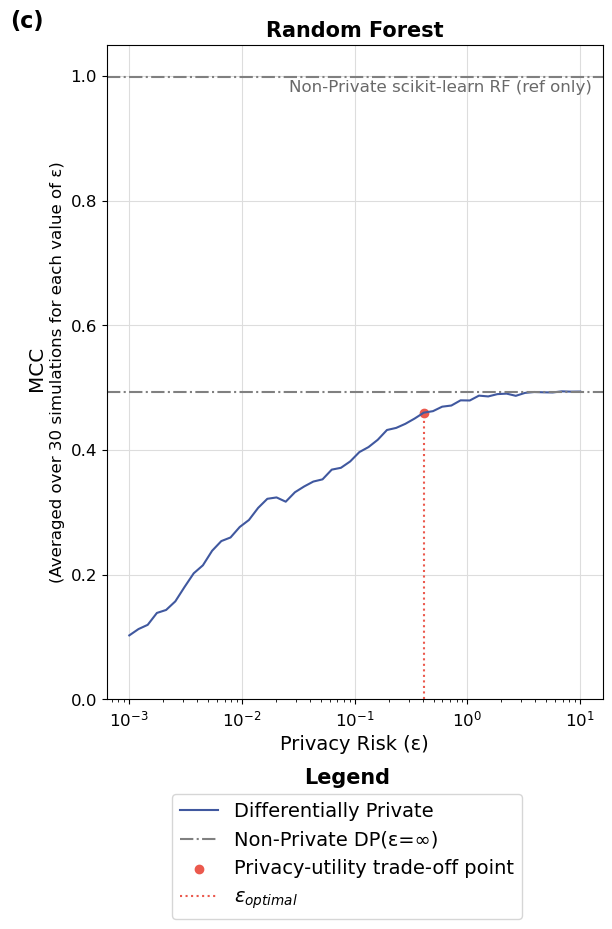

In [361]:
# Plot the tall version of the first graph that includes both non-DP lines

# Create the figure with the specified size
fig_rf1 = plt.figure(figsize=(6.4, 8.5))

# Plot the results
plt.semilogx(epsilons[:-1], avg_DPrf_mcc, color='#40589F', label="Differentially Private")

# Use list comprehension to plot multiple horizontal lines
[plt.axhline(y=y, color=color, linestyle=style, label=label) for y, color, style, label in zip(
    [rf_noDP_mcc_list.mean(), rf_DP_mcc_list.mean()],
    ['grey', 'grey'],
    ['-.', '-.'],
    ["", "Non-Private DP(ε=∞)"])
]

# Define the optimal epsilon point
optimal = [0.409492, 0.459761]

plt.scatter(optimal[0], optimal[1], color ='#EB594D', marker = "o", label = "Privacy-utility trade-off point")
plt.plot([optimal[0], optimal[0]], [0, optimal[1]], linestyle=':', color='#EB594D', label=r'$\epsilon_{optimal}$')
plt.ylim(0, 1.05)

plt.title("Random Forest", fontweight='bold', fontsize=15)
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.xlabel("Privacy Risk (ε)", fontsize=14)
plt.ylabel("(Averaged over 30 simulations for each value of ε)", fontsize=12)
fig_rf1.figure.supylabel("MCC", fontsize="x-large", x=0)

# Set font size for tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add the legend below the plot
handles, labels = plt.gca().get_legend_handles_labels()
legend = fig_rf1.legend(handles, labels, loc='upper center', ncol=1, bbox_to_anchor=(0.5, .01), fontsize=14)

# Add a separate text elements
plt.figtext(0.5, .01, "Legend", ha="center", fontsize=plt.gca().title.get_fontsize(), fontweight='bold')
plt.figtext(0, 0.9, "(c)", ha="center", fontsize=16, fontweight='bold')
plt.figtext(0.41, 0.825, 'Non-Private scikit-learn RF (ref only)', horizontalalignment='left', wrap=True, color='dimgray', fontsize=12)

# Save and show the plot
plt.savefig('Figures/RF-Graph1-A.png', dpi=600, bbox_inches='tight') 
plt.show()

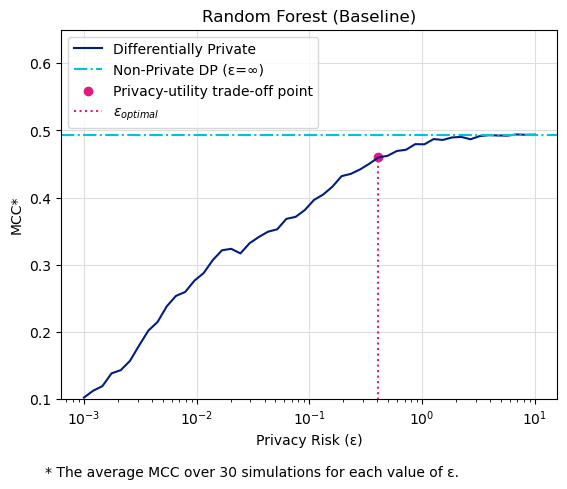

In [109]:
# Plot the regular size version of the first graph that only includes DP (e=inf)

# Plot the results
plt.semilogx(epsilons[:-1], avg_DPrf_mcc, color='#001E82', label="Differentially Private") # :-1 when infinity is included
plt.axhline(y=rf_DP_mcc_list.mean(), color='#00C2DE', linestyle='-.', label="Non-Private DP (ε=∞)")

# Define the optimal epsilon point
optimal = [0.409492, 0.459761]

plt.scatter(optimal[0], optimal[1], color ='#E31A82', marker = "o", label = "Privacy-utility trade-off point")
plt.plot([optimal[0], optimal[0]], [0, optimal[1]], linestyle=':', color='#E31A82', label=r'$\epsilon_{optimal}$')
plt.ylim(0.1, 0.65)

plt.title("Random Forest (Baseline)")
plt.xlabel("Privacy Risk (ε)")
plt.ylabel("MCC*")
plt.legend(loc="upper left")
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)

plt.figtext(0.1, -0.05, '* The average MCC over 30 simulations for each value of ε.', horizontalalignment='left', wrap=True ) 

# Save and show the plot
plt.savefig('Figures/RF-Graph1-B.png', dpi=800, bbox_inches='tight') 
plt.show()

rf_runtime.loc['End Time', 'Baseline'] = time.time()

### 4: The Impact of SMOTE

In [44]:
rf_runtime.loc['Start Time', 'Smote'] = time.time()

# Define the data for the second graph using parallel processing

# Define data files and parameters
SMOTEtrain = ['fraudTrain_50.csv', 'fraudTrain_100.csv', 'fraudTrain_200.csv', 'fraudTrain_300.csv', 
              'fraudTrain_500.csv', 'fraudTrain_750.csv', 'fraudTrain_1000.csv', 'fraudTrain_2000.csv']
colNames = ['50_SMOTE', '100_SMOTE', '200_SMOTE', '300_SMOTE', 
            '500_SMOTE', '750_SMOTE', '1000_SMOTE', '2000_SMOTE']

epsilons = np.logspace(-3, 1, 50)
epsilons = np.append(epsilons, np.inf)
num_runs = 30

# Dictionaries to store the resulting dataframes
avg_DPrf_SMOTE_mcc_dict = {}
avg_rf_noDP_SMOTE_mcc_dict = {}

# Prepare a list of tasks
tasks_SMOTE = [(run, epsilon) for run in range(num_runs) for epsilon in epsilons]

# Loop through the training and test files
for file, name in zip(SMOTEtrain, colNames):
    # Load the datasets
    SMOTE_data = pd.read_csv(f'Datasets/{file}')
    X_train_SMOTE = SMOTE_data.drop(['is_fraud'], axis=1)
    y_train_SMOTE = SMOTE_data['is_fraud']

    # Convert dataframes to writeable numpy arrays for pipelining
    X_train_SMOTE = X_train_SMOTE.values
    y_train_SMOTE = y_train_SMOTE.values
    
    # Empty list for the loop to fill
    dprf_mcc_SMOTE_rows = []

    # Use joblib to parallelize the loop
    results_SMOTE = Parallel(n_jobs=-1)(
        delayed(train_DPrf)(run, epsilon, X_train_SMOTE, X_test_np, y_train_SMOTE, y_test_np)
        for run, epsilon in tqdm(tasks_SMOTE, desc="Processing", total=len(tasks_SMOTE))
    )

    # Convert data to dataframe
    dprf_mcc_SMOTE_df = pd.DataFrame(results_SMOTE)

    # Compute the average MCC across all runs
    grouped_mcc_SMOTE = dprf_mcc_SMOTE_df.groupby("epsilon")["mcc"].mean()

    # Separate the non-private MCC value (epsilon = infinity)
    avg_rf_noDP_SMOTE_mcc = grouped_mcc_SMOTE[np.inf]
    avg_DPrf_SMOTE_mcc = grouped_mcc_SMOTE.iloc[:-1]

    # Store the resulting dataframe in the dictionary
    avg_rf_noDP_SMOTE_mcc_dict[name] = avg_rf_noDP_SMOTE_mcc
    avg_DPrf_SMOTE_mcc_dict[name] = avg_DPrf_SMOTE_mcc

# Access the resulting dataframes using avg_DPrf_mcc_dict
print('Complete')


Processing:   1%|▎                          | 20/1530 [00:29<37:15,  1.48s/it]/Users/firefly/anaconda3/envs/IRP/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(

Processing: 100%|███████████████████████| 1530/1530 [1:13:12<00:00,  2.87s/it]

Processing:   1%|▎                          | 20/1530 [00:28<36:27,  1.45s/it]/Users/firefly/anaconda3/envs/IRP/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(

Processing: 100%|███████████████████████| 1530/1530 [1:13:29<00:00,  2.88s/it]

Processing:   1%|▎                          | 20/1530 [00:29<37:00,  1.47s/it]/Users/firefly/anaconda3/envs/IRP/lib/python3.11/site-package

Complete


In [45]:
# Add previously calculated baseline runs to the dictionaries
avg_rf_noDP_SMOTE_mcc_dict['Baseline'] = avg_rf_noDP_mcc.mean()
avg_DPrf_SMOTE_mcc_dict['Baseline'] = avg_DPrf_mcc

print(avg_rf_noDP_SMOTE_mcc_dict)
print(avg_DPrf_SMOTE_mcc_dict)

{'50_SMOTE': 0.5161336756472957, '100_SMOTE': 0.5187541302965557, '200_SMOTE': 0.5254966224393198, '300_SMOTE': 0.5303932293915581, '500_SMOTE': 0.5434737143720483, '750_SMOTE': 0.5535767175817535, '1000_SMOTE': 0.5586965936924853, '2000_SMOTE': 0.5999256755888837, 'Baseline': 0.49364932779771137}
{'50_SMOTE': epsilon
0.001000     0.101556
0.001207     0.112009
0.001456     0.124930
0.001758     0.137272
0.002121     0.151570
0.002560     0.172619
0.003089     0.189206
0.003728     0.208414
0.004498     0.228713
0.005429     0.243371
0.006551     0.263369
0.007906     0.264768
0.009541     0.290440
0.011514     0.314631
0.013895     0.328336
0.016768     0.332261
0.020236     0.340649
0.024421     0.333721
0.029471     0.340296
0.035565     0.363122
0.042919     0.368178
0.051795     0.380152
0.062506     0.383726
0.075431     0.391155
0.091030     0.403067
0.109854     0.417954
0.132571     0.430701
0.159986     0.437834
0.193070     0.452742
0.232995     0.453070
0.281177     0.46679

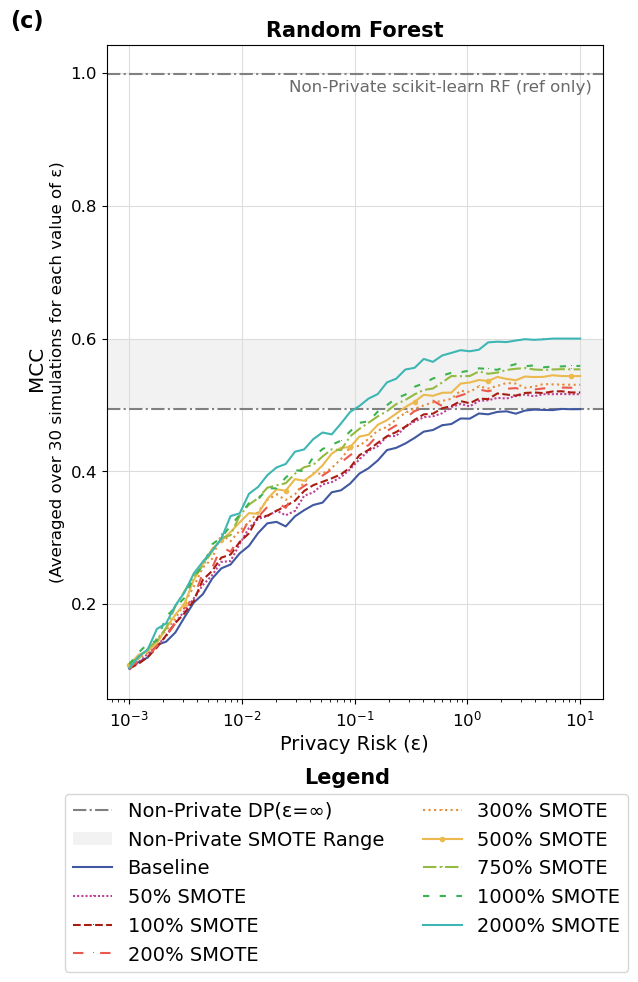

In [360]:
# Plot the tall version of the second graph

# Create the figure with the specified size
fig_rf2 = plt.figure(figsize=(6.4, 8.5))  # Reduced height for the plot area

# Plot the non-DP smote values
# Use list comprehension to plot multiple horizontal lines
[plt.axhline(y=y, color=color, linestyle=style, label=label) for y, color, style, label in zip(
    [rf_noDP_mcc_list.mean(), rf_DP_mcc_list.mean()],
    ['grey', 'grey'],
    ['-.', '-.'],
    ["", "Non-Private DP(ε=∞)"])
]

# Add range of non-DP smote values
rf_MCC_min = min(avg_rf_noDP_SMOTE_mcc_dict.values())
rf_MCC_max = max(avg_rf_noDP_SMOTE_mcc_dict.values())
plt.axhspan(rf_MCC_max, rf_MCC_min, facecolor='silver', alpha=0.2, label="Non-Private SMOTE Range")

# Plot the results from plot 1
plt.semilogx(epsilons[:-1], avg_DPrf_SMOTE_mcc_dict['Baseline'], color='#40589F', label="Baseline", marker=',', markevery=.1)


# Add the SMOTE lines for comparison
colors = ['#BE4196', '#A91C11', '#EB594D', '#E88C38', '#EBB94D', '#94BA42', '#3BB450', '#3EB6B4']
labels = ['50% SMOTE', '100% SMOTE', '200% SMOTE', '300% SMOTE', '500% SMOTE', '750% SMOTE', '1000% SMOTE', '2000% SMOTE']
widths = [1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5 ]
styles = [(0, (1, 1)), '--', (0, (5, 8)), ':', '-', '-.', (0, (3, 5)), '-' ]
markers= [",", ",", ",", ",", ".", ",", ",", ","] 

for name, color, label, width, style, marker in zip(colNames[:], colors, labels, widths, styles, markers):
    plt.semilogx(epsilons[:-1], avg_DPrf_SMOTE_mcc_dict[name], color=color, label=label, linewidth=width, linestyle=style, marker=marker, markevery=.1)

plt.title("Random Forest", fontweight='bold', fontsize=15)
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.xlabel("Privacy Risk (ε)", fontsize=14)
plt.ylabel("(Averaged over 30 simulations for each value of ε)", fontsize=12)
fig_rf2.figure.supylabel("MCC", fontsize="x-large", x=0)

# Set font size for tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add the legend below the plot
handles, labels = plt.gca().get_legend_handles_labels()
legend = fig_rf2.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, .01), fontsize=14)

# Add a separate text elements
plt.figtext(0.5, .01, "Legend", ha="center", fontsize=plt.gca().title.get_fontsize(), fontweight='bold')
plt.figtext(0, 0.9, "(c)", ha="center", fontsize=16, fontweight='bold')
plt.figtext(0.41, 0.825, 'Non-Private scikit-learn RF (ref only)', horizontalalignment='left', wrap=True, color='dimgray', fontsize=12)

# Save and show the plot
plt.savefig('Figures/RF-Graph2-A.png', dpi=600, bbox_inches='tight')
plt.show()

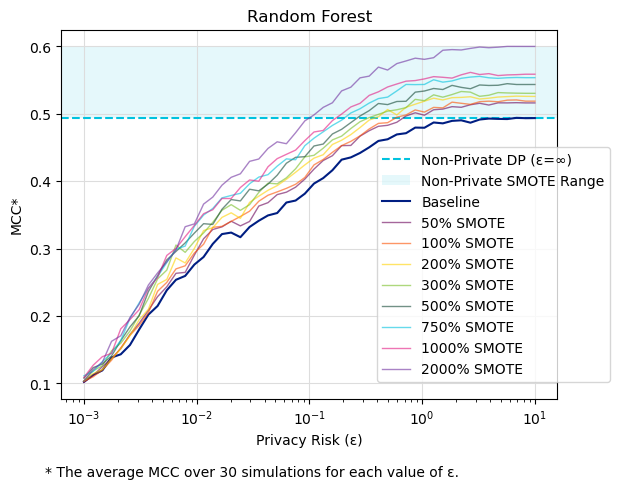

In [77]:
# Plot the regular size version of the second graph

# Plot the non-DP smote values
plt.axhline(y=avg_rf_noDP_SMOTE_mcc_dict['Baseline'], color='#00C2DE', linestyle='--', label="Non-Private DP (ε=∞)")

# Add range of non-DP smote values
rf_MCC_min = min(avg_rf_noDP_SMOTE_mcc_dict.values())
rf_MCC_max = max(avg_rf_noDP_SMOTE_mcc_dict.values())
plt.axhspan(rf_MCC_max, rf_MCC_min, facecolor='#00C2DE', alpha=0.1, label="Non-Private SMOTE Range")

# Plot the results from plot 1
plt.semilogx(epsilons[:-1], avg_DPrf_SMOTE_mcc_dict['Baseline'], color='#001E82', label="Baseline")
#plt.axhline(y=rf_noDP_mcc_list.mean(), color='#00C2DE', linestyle='--', label="Non-DP Baseline")

# Add the SMOTE lines for comparison
colors = ['#690058', '#FD5000', '#FFD200', '#78BF26', '#144835', '#00C2DE', '#E31A82', '#7030A0']
labels = ['50% SMOTE', '100% SMOTE', '200% SMOTE', '300% SMOTE', '500% SMOTE', '750% SMOTE', '1000% SMOTE', '2000% SMOTE']

for name, color, label in zip(colNames[:], colors, labels):
    plt.semilogx(epsilons[:-1], avg_DPrf_SMOTE_mcc_dict[name], color=color, alpha=0.6, linewidth=1, label=label) # removed .values from x

plt.title("Random Forest")
plt.xlabel("Privacy Risk (ε)")
plt.ylabel("MCC*")
#plt.legend(loc="best")
plt.legend(loc=1, bbox_to_anchor=(1.12, .7))
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.figtext(0.1, -0.05, '* The average MCC over 30 simulations for each value of ε.', horizontalalignment='left', wrap=True) 

# Save and show the plot
plt.savefig('Figures/RF-Graph2-B.png', dpi=400, bbox_inches='tight')
plt.show()

rf_runtime.loc['End Time', 'Smote'] = time.time()

In [48]:
# Calculate Runtimes
rf_runtime.loc['Runtime'] = rf_runtime.loc['End Time'] - rf_runtime.loc['Start Time']

# Output Runtime data
rf_runtime

,Setup,Compare,Baseline,Smote
Start Time,1721943457.51926,1721943458.40312,1721944254.384446,1721948672.204383
End Time,1721943458.398363,1721944254.381729,1721948672.200115,1721984883.256549
Runtime,0.879103,795.978609,4417.815669,36211.052166


In [49]:
print(rf_runtime.loc['Runtime'].sum())

41425.72554731369


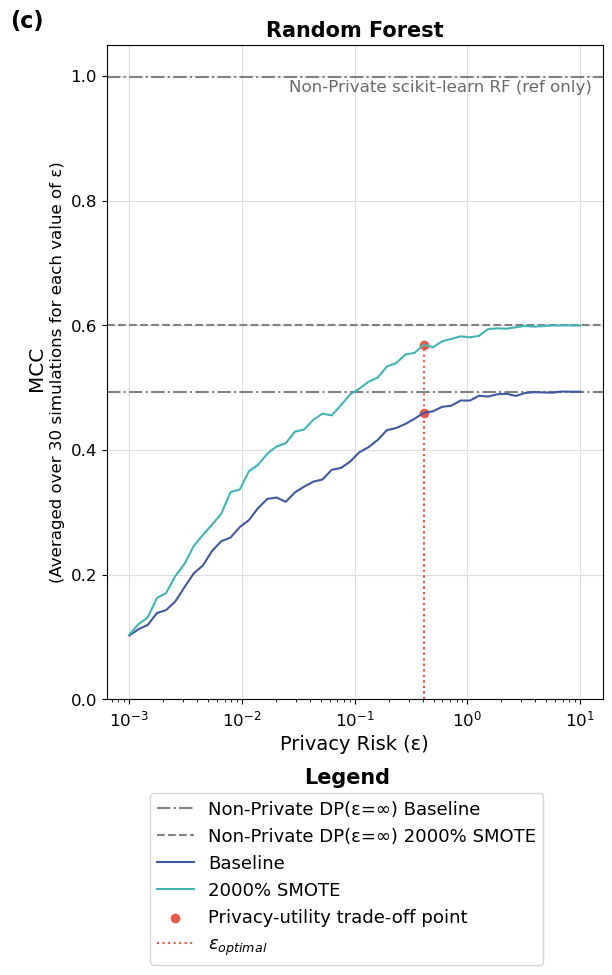

In [359]:
# Baseline to 2000_SMOTE comparison

# Create the figure with the specified size
fig_rf3 = plt.figure(figsize=(6.4, 8.5)) 

# Use list comprehension to plot multiple horizontal lines
[plt.axhline(y=y, color=color, linestyle=style, label=label) for y, color, style, label in zip(
    [rf_noDP_mcc_list.mean(), rf_DP_mcc_list.mean(), avg_rf_noDP_SMOTE_mcc_dict['2000_SMOTE']],
    ['grey', 'grey', 'grey'],
    ['-.', '-.', '--'],
    ["", "Non-Private DP(ε=∞) Baseline", "Non-Private DP(ε=∞) 2000% SMOTE"])
]

# Plot the results
plt.semilogx(epsilons[:-1], avg_DPrf_mcc, color='#40589F', label="Baseline") # :-1 when infinity is included
plt.semilogx(epsilons[:-1], avg_DPrf_SMOTE_mcc_dict['2000_SMOTE'], color='#3EB6B4', label="2000% SMOTE")

# Define the optimal epsilon point
#optimal = [0.409492, 0.459761]
optimal_smote = [0.409492, 0.569273]
plt.scatter(optimal[0], optimal[1], color ='#EB594D', marker = "o", label='Privacy-utility trade-off point')
plt.scatter(optimal_smote[0], optimal_smote[1], color ='#EB594D', marker = "o")
plt.plot([optimal[0], optimal[0]], [0, optimal[1]], linestyle=':', color='#EB594D', label=r'$\epsilon_{optimal}$')
plt.plot([optimal_smote[0], optimal_smote[0]], [0, optimal_smote[1]], linestyle=':', color='#EB594D')
plt.ylim(0, 1.05)

plt.title("Random Forest", fontweight='bold', fontsize=15)
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.xlabel("Privacy Risk (ε)", fontsize=14)
plt.ylabel("(Averaged over 30 simulations for each value of ε)", fontsize=12)
fig_rf3.figure.supylabel("MCC", fontsize="x-large", x=0)

# Set font size for tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add the legend below the plot
handles, labels = plt.gca().get_legend_handles_labels()
legend = fig_rf3.legend(handles, labels, loc='upper center', ncol=1, bbox_to_anchor=(0.5, .01), fontsize=13)

# Add a separate text elements
plt.figtext(0.5, 0.01, "Legend", ha="center", fontsize=plt.gca().title.get_fontsize(), fontweight='bold')
plt.figtext(0, 0.9, "(c)", ha="center", fontsize=16, fontweight='bold')
plt.figtext(0.41, 0.825, 'Non-Private scikit-learn RF (ref only)', horizontalalignment='left', wrap=True, color='dimgray', fontsize=12)

# Save and show the plot
plt.savefig('Figures/RF-Graph3.png', dpi=600, bbox_inches='tight') 
plt.show()

## Archived Code
This section contains the non-pipelined versions of the code base for reference.

In [6]:
# Archived code - Use parallel processing version instead.

# Define first graph (no parallel processing)
epsilons = np.logspace(-3, 1, 50)
epsilons = np.append(epsilons, np.inf)
num_runs = 30

DPrf_mcc_rows = []

for run in tqdm(range(num_runs)):
    for epsilon in epsilons:
        DPrf = dp.models.RandomForestClassifier(epsilon=epsilon, random_state=(42 + run), 
                                                bounds=bounds, classes=classes, 
                                                max_depth=15, n_estimators=10)
        DPrf.fit(X_train, y_train)
        y_pred_DPrf = DPrf.predict(X_test)
        DPrf_mcc_rows.append(
            {
                "epsilon": epsilon,
                "run": run,
                "mcc": matthews_corrcoef(y_test, y_pred_DPrf),
            }
        )

# Convert data to dataframe and average across all runs
DPrf_mcc_df = pd.DataFrame(DPrf_mcc_rows).set_index("epsilon")
grouped_mcc = DPrf_mcc_df.groupby("epsilon")["mcc"].mean()

# Separate the non-private MCC values (epsilon = infinity)
avg_rf_noDP_mcc = grouped_mcc[np.inf]
avg_DPrf_mcc = grouped_mcc.iloc[:-1]

print(avg_rf_noDP_mcc)
print(avg_DPrf_mcc)

100%|███████████████████████████████████████████| 1/1 [20:19<00:00, 1219.26s/it]

0.3776902312833661
epsilon
0.001000     0.086154
0.001207     0.115723
0.001456     0.121032
0.001758     0.135169
0.002121     0.122533
0.002560     0.193143
0.003089     0.198866
0.003728     0.211677
0.004498     0.242492
0.005429     0.187710
0.006551     0.248722
0.007906     0.256225
0.009541     0.229798
0.011514     0.219773
0.013895     0.303725
0.016768     0.235521
0.020236     0.291731
0.024421     0.256842
0.029471     0.275172
0.035565     0.268332
0.042919     0.333226
0.051795     0.284308
0.062506     0.276015
0.075431     0.295528
0.091030     0.301753
0.109854     0.303289
0.132571     0.320427
0.159986     0.340129
0.193070     0.353531
0.232995     0.385005
0.281177     0.344204
0.339322     0.368343
0.409492     0.399816
0.494171     0.355498
0.596362     0.376457
0.719686     0.386211
0.868511     0.354844
1.048113     0.386211
1.264855     0.395137
1.526418     0.385005
1.842070     0.375839
2.222996     0.394548
2.682696     0.383190
3.237458     0.388012
3.906

In [9]:
# Archived code - Use parallel processing version instead.

# Define the data for the second graph (no-pipelining)

# Define data files and parameters
SMOTEtrain = ['fraudTrain_50.csv', 'fraudTrain_100.csv', 'fraudTrain_200.csv', 'fraudTrain_300.csv', 
              'fraudTrain_500.csv', 'fraudTrain_750.csv', 'fraudTrain_1000.csv', 'fraudTrain_2000.csv']
colNames = ['50_SMOTE', '100_SMOTE', '200_SMOTE', '300_SMOTE', '500_SMOTE', '750_SMOTE', '1000_SMOTE', '2000_SMOTE']

epsilons = np.logspace(-3, 1, 50)
epsilons = np.append(epsilons, np.inf)
num_runs = 30

# Dictionaries to store the resulting dataframes
avg_DPrf_SMOTE_mcc_dict = {}
avg_rf_noDP_SMOTE_mcc_dict = {}

# Loop through the training and test files
for file, name in tqdm(zip(SMOTEtrain, colNames), total=len(SMOTEtrain)):

    # Load the datasets
    # Convert to writable numpy arrays
    SMOTE_data = pd.read_csv(f'Datasets/{file}')  # Test established previously
    X_train_SMOTE = SMOTE_data.drop(['is_fraud'], axis=1).values
    y_train_SMOTE = SMOTE_data['is_fraud'].values

    # Empty list for the loop to fill
    dprf_mcc_SMOTE_rows = []
    
    for run in tqdm(range(num_runs), desc=f"Runs for {name}"):
        for epsilon in epsilons:
            DPrf_SMOTE = dp.models.RandomForestClassifier(epsilon=epsilon, 
                                                          random_state=(42 + run), 
                                                          bounds=bounds, 
                                                          classes=classes, 
                                                          max_depth=15,
                                                          n_estimators=10)
            DPrf_SMOTE.fit(X_train_SMOTE, y_train_SMOTE)
            y_pred_DPrf_SMOTE = DPrf_SMOTE.predict(X_test.values)
            dprf_mcc_SMOTE_rows.append( 
                {
                    "epsilon": epsilon,
                    "run": run,
                    "mcc": matthews_corrcoef(y_test, y_pred_DPrf_SMOTE), 
                } 
            ) # Test established previously

    # Convert data to dataframe
    dprf_mcc_SMOTE_df = pd.DataFrame(dprf_mcc_SMOTE_rows)

    # Compute the average MCC across all runs
    grouped_mcc_SMOTE = dprf_mcc_SMOTE_df.groupby("epsilon")["mcc"].mean()

    # Separate the non-private MCC value (epsilon = infinity)
    avg_rf_noDP_SMOTE_mcc = grouped_mcc_SMOTE[np.inf]
    avg_DPrf_SMOTE_mcc = grouped_mcc_SMOTE.iloc[:-1]
   
    # Store the resulting dataframe in the dictionary
    avg_rf_noDP_SMOTE_mcc_dict[name] = avg_rf_noDP_SMOTE_mcc
    avg_DPrf_SMOTE_mcc_dict[name] = avg_DPrf_SMOTE_mcc

# Access the resulting dataframes using avg_DPrf_mcc_dict
print('Complete')


  0%|                                                     | 0/1 [00:00<?, ?it/s]

Processing:  37%|███████████▌                   | 19/51 [03:11<05:22, 10.09s/it]


Runs for 50_SMOTE: 100%|████████████████████████| 1/1 [20:48<00:00, 1248.29s/it]

100%|███████████████████████████████████████████| 1/1 [20:48<00:00, 1248.80s/it]

Complete
